In [1]:
import pandas as pd
import folium as fo
import selenium
import numpy as np
import datetime
import seaborn as sns
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import json
pd.set_option('mode.chained_assignment', None)
sns.set_style({'axes.facecolor':'white','axes.edgecolor': '1', 'grid.color': '0.4', 'font.family':'Calibri'})

# Violation frequency  
## Violation frequency by violation category  
Regrouping violations in common categories will need less plots while maintening readability and finer analysis.  
To do so, we created 5 categories (food safety, hygiene, equipment, recidivism and others).  
For the analysis, we first map violation's id to their new category and then proceed as usual.

In [2]:
violation_category_mapping = pd.read_csv('resources/violation-id-meaning.csv').rename(columns={'Violation ID': 'id', 'Category': 'category'})
violation_category_mapping.index = violation_category_mapping.id
violation_category_mapping = violation_category_mapping.category

violation_categories = violation_category_mapping.unique()
violation_category_mapping.head()

id
1    Food safety
2    Food safety
3    Food safety
4    Food safety
5        Hygiene
Name: category, dtype: object

We also restrict the analysis to certain types of facility: ie restaurants and grocery stores.  

In [3]:
inspections = pd.read_parquet('resources/cleaned_franchises.parquet').rename(columns={'Inspection Date': 'date', 'Nb Violations': 'nb_violations'})
inspections = inspections[inspections.date.apply(lambda x: x.year not in [2010, 2018, 2019])]
inspections.head()

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,date,Inspection Type,Results,...,Re-inspection,Community,Neighborhood,Ward,Precinct,Violation IDs,nb_violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Inspection ID,,,,,,,,,,,,,,,,,,,,,
2129810,PICCOLO MONDO CAFE,PICCOLOMONDOCAFE,1908007,Restaurant,High,1642 E 56TH ST,60637,2017-12-29,Suspect food poisoning,Fail,...,False,HYDE PARK,HYDE PARK,5,35,"[3, 18, 34, 35, 38]",5,1,1,3
2129821,STARBUCKS COFFEE # 216,STARBUCKS,2398564,Restaurant,Medium,401 E ONTARIO ST,60611,2017-12-29,Canvass,Pass,...,False,NEAR NORTH SIDE,STREETERVILLE,42,7,[37],1,0,0,1
2129811,NORTHSIDE GRILL,NORTHSIDEGRILL,2404396,Restaurant,High,4351 N ELSTON AVE,60641,2017-12-29,Canvass,Pass,...,False,IRVING PARK,"IRVING PARK,AVONDALE",39,25,"[30, 32, 33, 34, 35, 38, 41]",7,0,0,7
2129808,DUNKIN DONUTS,DUNKINDONUTS,2391841,Restaurant,Medium,6701 S JEFFERY BLVD,60649,2017-12-29,Complaint,Pass,...,False,SOUTH SHORE,"SOUTH SHORE, GRAND CROSSING",5,1,[21],1,0,1,0
2129815,THE LUNCH ROOM,THELUNCHROOM,2559651,Restaurant,High,70 W MADISON ST,60602,2017-12-29,License,Pass,...,False,LOOP,LOOP,42,9,[None],0,0,0,0


In [4]:
categorized_violations = pd.read_parquet('resources/violations_oriented.parquet').rename(columns={'Violation ID': 'id', 'Inspection Date': 'date'})
categorized_violations.index = categorized_violations.date
categorized_violations['category'] = categorized_violations.id.map(lambda x: violation_category_mapping.get(x))

## Franchise oriented analysis

In [5]:
columns_rename = {'AKA Name': 'name', 'License #': 'license', 'Ward': 'ward', 'Violation IDs': 'violations', 'Inspection Date': 'date', 'Results': 'result', 'Risk': 'risk'}
columns_filter = columns_rename.values()
violations = pd.read_parquet('resources/cleaned_franchises.parquet').rename(columns=columns_rename)[columns_filter]
violations.date = violations.date.map(lambda x: x.year)
violations.columns

Index(['name', 'license', 'ward', 'violations', 'date', 'result', 'risk'], dtype='object')

In [6]:
violation_category_mapping = pd.read_csv('resources/violation-id-meaning.csv').rename(columns={'Violation ID': 'id', 'Category': 'category'})
violation_category_mapping.index = violation_category_mapping.id
violation_category_mapping = violation_category_mapping.category

violation_categories = violation_category_mapping.unique().tolist()
violation_categories.remove('Other')
'Violations categories are: ' + ' - '.join(violation_category_mapping.unique())

'Violations categories are: Food safety - Hygiene - Equipment - Recidivism - Other'

In [7]:
studied_franchises = ['SUBWAY', 'DUNKINDONUTS', 'MCDONALDS',\
                     'STARBUCKS', 'BURGERKING', 'POPEYES',\
                     'POTBELLYSANDWICH', 'CHIPOTLE', 'KFC',\
                     'HAROLDSCHICKEN', 'DOMINOS', 'WENDYS',\
                     'PIZZAHUT', 'AUBONPAIN', 'PAPAJOHNSPIZZA',\
                     'JAMBAJUICE', 'WINGSTOP', 'FRESHII',\
                     'JIMMYJOHNS', 'JJFISH',]
print('We are studying {} franchises.'.format(len(studied_franchises)))


We are studying 20 franchises.


## I] Franchises vs the rest of Chicago  
### 1] Average inspections per license 

In [8]:
licenses_per_name = violations[['name', 'license']].groupby(by='name').nunique()[['license']].rename(columns={'license': 'licenses'}).sort_values(by='licenses', ascending=False)
licenses_per_name.head()

,licenses
name,
SUBWAY,393
DUNKINDONUTS,270
STARBUCKS,240
MCDONALDS,175
BURGERKING,102


In [9]:
inspections_per_name = violations.copy()[['name']]
inspections_per_name['inspections'] = 1
inspections_per_name = inspections_per_name.groupby(by='name').count().sort_values(by='inspections', ascending=False)
inspections_per_name.head()

,inspections
name,
SUBWAY,3239
DUNKINDONUTS,1831
MCDONALDS,1606
STARBUCKS,1107
BURGERKING,545


In [10]:
avg_inspections_per_license = licenses_per_name.join(inspections_per_name)
avg_inspections_per_license['rate'] = avg_inspections_per_license.inspections / avg_inspections_per_license.licenses
avg_inspections_per_license = avg_inspections_per_license.drop(['inspections', 'licenses'], axis=1)
avg_inspections_per_license['is_franchise'] = avg_inspections_per_license.index.isin(studied_franchises)
avg_inspections_per_license.is_franchise = avg_inspections_per_license.is_franchise.map(lambda x: 'Franchise' if x else 'Individual')

In [11]:
def is_franchise(x):
    if x in studied_franchises:
        return 'Franchise'
    elif franchise_size_dict[x] in ['Huge','Large']:
        return 'Franchise'
    elif franchise_size_dict[x] == 'Medium':
        return 'Small Franchise'
    else:
        return 'Non-Franchise'

franchise_size_dict = pd.read_pickle('resources/franchise_metadata.pkl')['Size'].to_dict()
avg_inspections_per_license['is_franchise'] = avg_inspections_per_license.index.map(is_franchise)

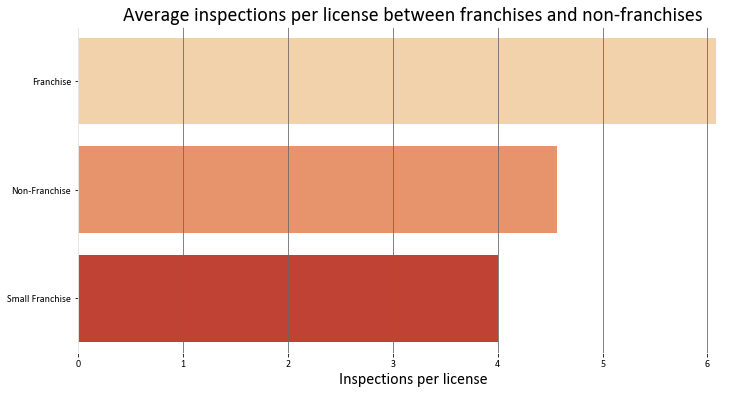

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.set_palette(sns.color_palette("OrRd", 3))
bar = sns.barplot(x='rate', y='is_franchise', data=avg_inspections_per_license.groupby(by='is_franchise').mean().reset_index(), ax=ax)
bar.set_title('Average inspections per license between franchises and non-franchises', fontsize=20)
bar.set_xlabel("Inspections per license", fontsize=16)
bar.set_ylabel('', fontsize=16)
bar.grid(axis='x')

fig.savefig('results/general/inspections_avg_franchise_individuals.png')

Franchises are more inspected :)

### 2] Failed inspections

In [13]:
passed_inspections = inspections.copy().rename(columns={'AKA Name': 'name', 'Results': 'result', 'Inspection Date': 'date'})[['name', 'result', 'date']]
passed_inspections.date = passed_inspections.date.map(lambda x: x.year)
passed_inspections.name = passed_inspections.name.apply(is_franchise)
passed_inspections.result = passed_inspections.result.isin(['Fail'])
passed_inspections_rate = passed_inspections.groupby(by=['name', 'date']).mean()
passed_inspections_rate.result = passed_inspections_rate.result * 100
passed_inspections_rate.head()

result
name      date           
Franchise 2011  17.053643
          2012  18.067227
          2013  15.458580
          2014  18.436482
          2015  20.810056

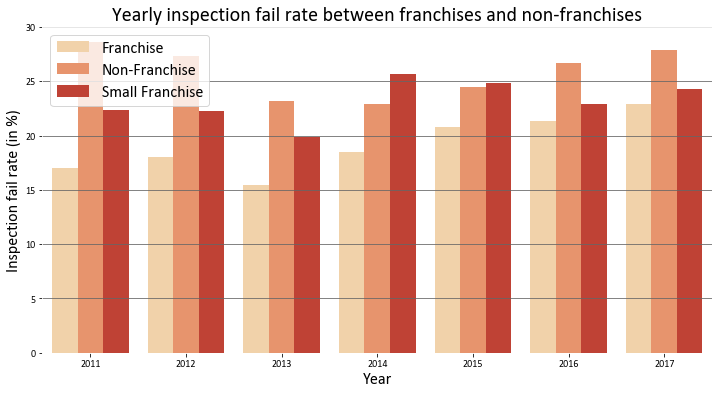

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.set_palette(sns.color_palette("OrRd", 3))
bar = sns.barplot(x='date', y='result', hue='name', data=passed_inspections_rate.reset_index(), ax=ax)
bar.set_title('Yearly inspection fail rate between franchises and non-franchises', fontsize=20)
bar.legend(fontsize=16).set_title("")
bar.set_xlabel("Year", fontsize=16)
bar.set_ylabel('Inspection fail rate (in %)', fontsize=16)
bar.grid(axis='y')

fig.savefig('results/general/fail_rate.png')

In [15]:
# fail rate is highest for non franchises.

### 3] Mean number of violations

In [16]:
passed_inspections = inspections.copy().rename(columns={'AKA Name': 'name', 'Inspection Date': 'date'})[['name', 'nb_violations', 'date']]
passed_inspections.date = passed_inspections.date.map(lambda x: x.year)
passed_inspections = passed_inspections[(passed_inspections.date > 2010) & (passed_inspections.date < 2018)]
passed_inspections.name = passed_inspections.name.apply(is_franchise)
passed_inspections_rate = passed_inspections.groupby(by=['name', 'date']).mean()
passed_inspections_rate.head()

nb_violations
name      date               
Franchise 2011       3.256205
          2012       3.252941
          2013       2.932692
          2014       3.070358
          2015       3.265363

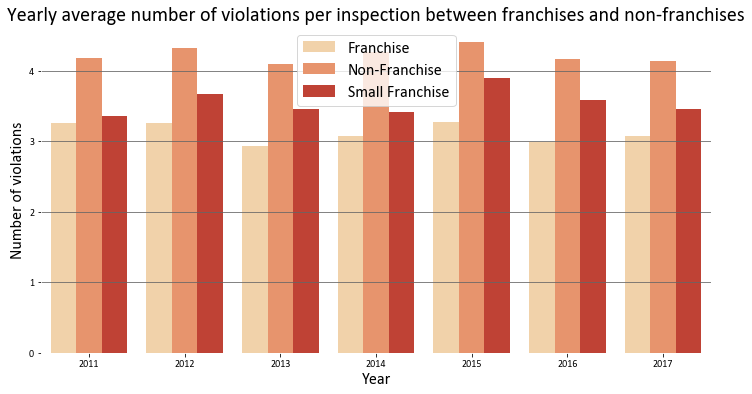

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.set_palette(sns.color_palette("OrRd", 3))

bar = sns.barplot(x='date', y='nb_violations', hue='name', data=passed_inspections_rate.reset_index(), ax=ax)
bar.set_title('Yearly average number of violations per inspection between franchises and non-franchises', fontsize=20)
bar.legend(fontsize=16).set_title("")
bar.set_xlabel("Year", fontsize=16)
bar.set_ylabel('Number of violations', fontsize=16)
bar.grid(axis='y')

fig.savefig('results/general/nb_violations.png')

## I-A) socio-economical correlation

In [18]:
inspections['is_franchise'] = inspections['AKA Name'].apply(is_franchise)
inspections.head(2)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,date,Inspection Type,Results,...,Community,Neighborhood,Ward,Precinct,Violation IDs,nb_violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity,is_franchise
Inspection ID,,,,,,,,,,,,,,,,,,,,,
2129810,PICCOLO MONDO CAFE,PICCOLOMONDOCAFE,1908007,Restaurant,High,1642 E 56TH ST,60637,2017-12-29,Suspect food poisoning,Fail,...,HYDE PARK,HYDE PARK,5,35,"[3, 18, 34, 35, 38]",5,1,1,3,Non-Franchise
2129821,STARBUCKS COFFEE # 216,STARBUCKS,2398564,Restaurant,Medium,401 E ONTARIO ST,60611,2017-12-29,Canvass,Pass,...,NEAR NORTH SIDE,STREETERVILLE,42,7,[37],1,0,0,1,Franchise


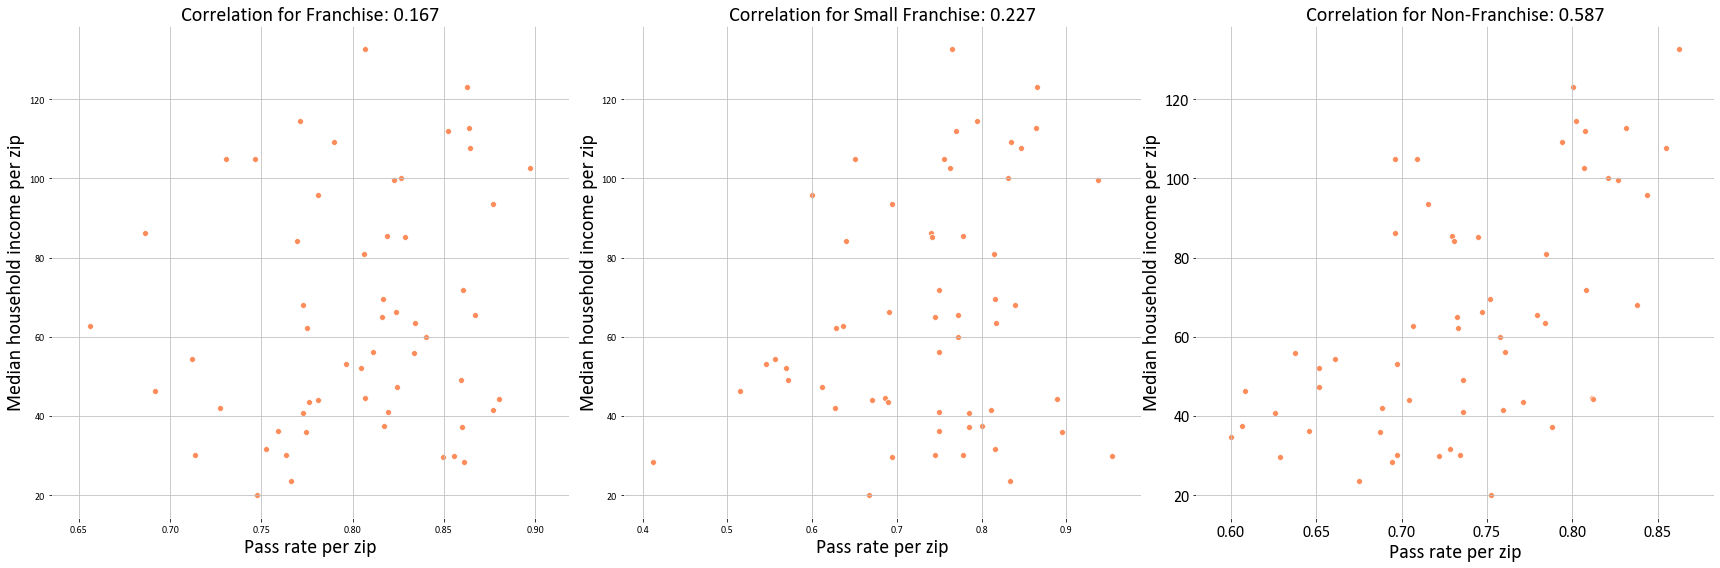

In [32]:
sns.set_palette(sns.color_palette("OrRd", 1))

df_zip_codes= pd.read_parquet('resources/zip_infos.parquet')
pass_rate_zip = inspections[['AKA Name','License #','Zip','Results','is_franchise']].rename(columns={'AKA Name':'name'})
groups = ['Franchise','Small Franchise','Non-Franchise']

fig, axs = plt.subplots(1, len(groups), figsize=(24, 8))


for i, f in enumerate(groups):

    df = pass_rate_zip[pass_rate_zip.is_franchise == f]
    df_pass = df[df.Results == 'Pass']
    df_pass_rate = pd.DataFrame(df_pass.groupby('Zip').size()/ \
                                   df.groupby('Zip').size()).rename(columns={0:'Pass rate'})

    df_joined = df_pass_rate.join(df_zip_codes)
    median_income = df_zip_codes.columns[1]
    data_ = df_pass_rate.columns[0]

    sns.scatterplot(x=data_, y=median_income, data=df_joined[[data_, median_income]], ax= axs[i]);
    axs[i].set_title('Correlation for {0}: {1}'.format(f, "%.3f" % df_joined[data_].corr(df_joined[median_income])),fontsize=20)
    axs[i].set_xlabel('Pass rate per zip',fontsize=20)
    plt.tight_layout()
    #plt.show()
    axs[i].set_ylabel('Median household income per zip', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    axs[i].grid()


    
fig.savefig('results/general/median_income_passrate.png')

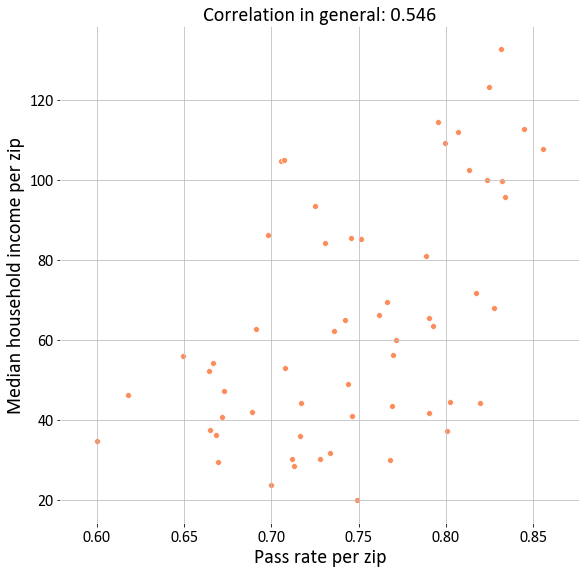

In [33]:
fig, ax = plt.subplots( figsize=(8, 8))

df = pass_rate_zip
df_pass = df[df.Results == 'Pass']
df_pass_rate = pd.DataFrame(df_pass.groupby('Zip').size()/ \
                               df.groupby('Zip').size()).rename(columns={0:'Pass rate'})

df_joined = df_pass_rate.join(df_zip_codes)
median_income = df_zip_codes.columns[1]
data_ = df_pass_rate.columns[0]

sns.scatterplot(x=data_, y=median_income, data=df_joined[[data_, median_income]], ax= ax);
ax.set_title('Correlation in general: {0}'.format("%.3f" % df_joined[data_].corr(df_joined[median_income])),fontsize=20)
ax.set_xlabel('Pass rate per zip',fontsize=20)
plt.tight_layout()
#plt.show()
ax.set_ylabel('Median household income per zip', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.grid()


    
fig.savefig('results/general/median_income_passrate_general.png')

In [21]:
franchise_metadata = pd.read_pickle('resources/franchise_metadata.pkl')['Size']
franchise_metadata.value_counts()

Small     11973
Medium      227
Large        17
Huge          5
Name: Size, dtype: int64

## II] Franchise groups vs each others  
This time, we will group every franchise in a group (ie: burgers, wraps, ...).  
This may reveal some interesting facts about different franchise types.

In [22]:
def franchise_map(franchise):
    if franchise in ['KFC', 'POPEYES', 'HAROLDSCHICKEN', 'WINGSTOP', 'JJFISH']: return 'Chicken/Fish'
    elif franchise in ['SUBWAY', 'POTBELLYSANDWICH', 'JIMMYJOHNS', 'AUBONPAIN']: return 'Sandwich'
    elif franchise in ['PIZZAHUT', 'DOMINOS', 'PAPAJOHNSPIZZA']: return 'Pizza'
    elif franchise in ['MCDONALDS', 'BURGERKING', 'WENDYS']: return 'Burger'
    elif franchise in ['JAMBAJUICE', 'STARBUCKS','DUNKINDONUTS']: return 'Drink'
    elif franchise in ['FRESHII','CHIPOTLE']: return 'Bowl/Burrito'
    return 'Other'

<Figure size 432x288 with 0 Axes>

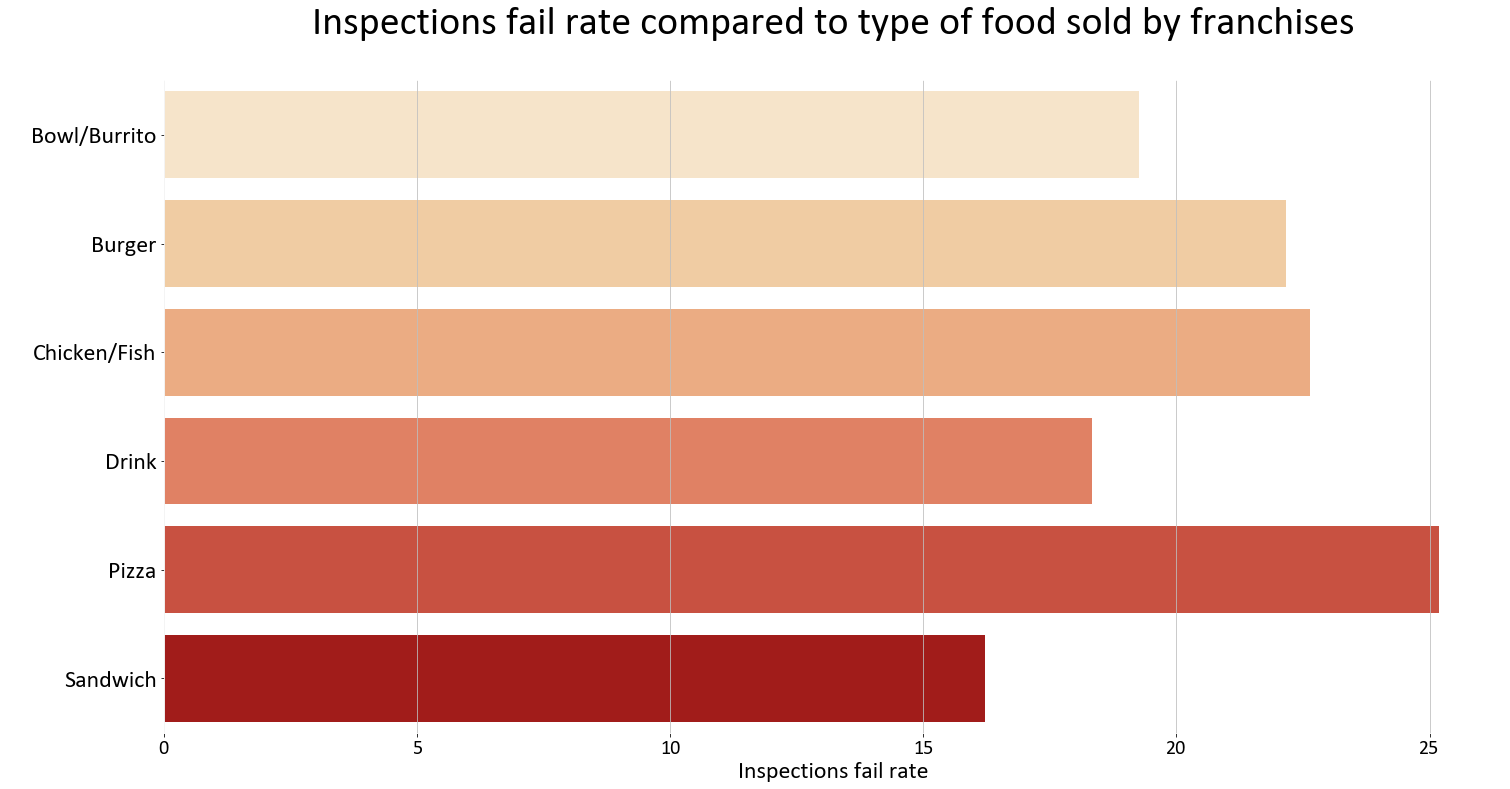

In [23]:
#average pass rate per each group

grouped_franchises = inspections[(inspections['AKA Name'].isin(studied_franchises))].rename(columns={'AKA Name':'name'})
grouped_franchises['year'] = grouped_franchises.date.apply(lambda x: x.year)
grouped_franchises.name = grouped_franchises.name.apply(franchise_map)
grouped_franchises_fail_rate = pd.DataFrame(100 *grouped_franchises[grouped_franchises.Results == 'Fail'].groupby(by='name').size() / \
                            grouped_franchises.groupby(by='name').size()).rename(columns={0:'rate'}).reset_index()

sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
sns.set_style({'axes.facecolor':'white','axes.edgecolor': '1', 'grid.color': '0.75', 'font.family':'Calibri'})

fig, ax = plt.subplots(figsize=(24, 12))

sns.set_palette(sns.color_palette("OrRd", 6))
bar = sns.barplot(x="rate", y="name", data=grouped_franchises_fail_rate,\
                  label="Total", ax=ax)
bar.set_title('Inspections fail rate compared to type of food sold by franchises\n', fontsize=40)
bar.set_xlabel('Inspections fail rate', fontsize=24)
bar.set_ylabel(' ', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=24)
bar.grid(axis='x')

fig.savefig('results/general/fail_rate_franchisetype.png')

In [24]:
grouped_franchises_licenses = licenses_per_name[licenses_per_name.index.isin(studied_franchises)]
grouped_franchises_licenses.index = grouped_franchises_licenses.index.map(franchise_map)
grouped_franchises_licenses = grouped_franchises_licenses.groupby(by='name').sum()

grouped_franchises_inspections = inspections_per_name[inspections_per_name.index.isin(studied_franchises)]
grouped_franchises_inspections.index = grouped_franchises_inspections.index.map(franchise_map)
grouped_franchises_inspections = grouped_franchises_inspections.groupby(by='name').sum()

inpections_per_license_per_inspection_group = grouped_franchises_licenses.join(grouped_franchises_inspections)
inpections_per_license_per_inspection_group['group'] = inpections_per_license_per_inspection_group.index
inpections_per_license_per_inspection_group['rate'] = inpections_per_license_per_inspection_group.inspections / inpections_per_license_per_inspection_group.licenses
inpections_per_license_per_inspection_group = inpections_per_license_per_inspection_group[inpections_per_license_per_inspection_group.group != 'Other']


<Figure size 432x288 with 0 Axes>

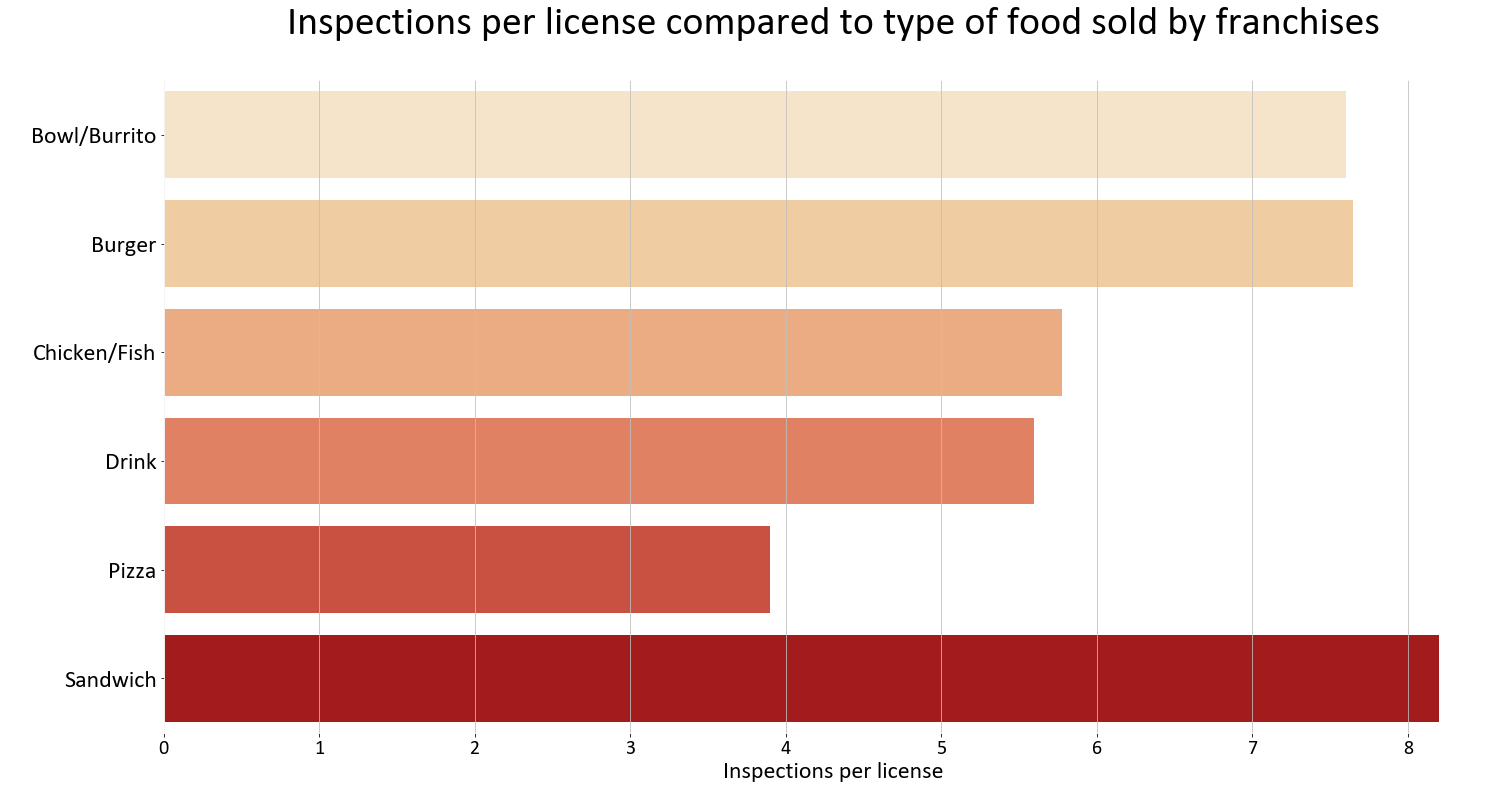

In [25]:
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
sns.set_style({'axes.facecolor':'white','axes.edgecolor': '1', 'grid.color': '0.75', 'font.family':'Calibri'})

fig, ax = plt.subplots(figsize=(24, 12))

sns.set_palette(sns.color_palette("OrRd", 6))
bar = sns.barplot(x="rate", y="group", data=inpections_per_license_per_inspection_group,\
                  label="Total", ax=ax)
bar.set_title('Inspections per license compared to type of food sold by franchises\n', fontsize=40)
bar.set_xlabel('Inspections per license', fontsize=24)
bar.set_ylabel(' ', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=24)
bar.grid(axis='x')
fig.savefig('results/general/inspection_per_license_franchisetype.png')

In [26]:
franchises_inspections = violations[violations.name.isin(studied_franchises)]

groups_inspections = franchises_inspections.copy()
groups_inspections.name = groups_inspections.name.map(franchise_map)
groups_violations = groups_inspections.explode('violations').rename(columns={'violations': 'id'})


violations_per_license = groups_violations[['name', 'id', 'date']]
violations_per_license = violations_per_license[violations_per_license.id != 'None']
violations_per_license['v_count'] = 1
violations_per_license = violations_per_license.drop('id', axis=1)

violations_overall = violations_per_license.drop('date', axis=1).groupby(by=['name']).sum().v_count / grouped_franchises_licenses.licenses

print("correlation between inspection per license and fail rate : {0}"\
      .format(inpections_per_license_per_inspection_group.rate.corr(grouped_franchises_fail_rate.set_index('name').rate)))
print("correlation between inspection per license and violation per license : {0}"\
      .format(inpections_per_license_per_inspection_group.rate.corr(violations_overall)))
print("correlation between fail rate and violation per license : {0}"\
      .format(violations_overall.corr(grouped_franchises_fail_rate.set_index('name').rate)))


correlation between inspection per license and fail rate : -0.6862054032363548
correlation between inspection per license and violation per license : 0.8149533521704042
correlation between fail rate and violation per license : -0.335698440496499


MORE INSPECTED FRANCHISE TYPE HAS LESS FAIL RATE. VIOLATION COUNT DOES NOT REALLY TELL MUCH ABOUT PASS/FAIL

# Main cause of failed inspections

In [27]:
grouped_franchises_fail = grouped_franchises[grouped_franchises.Results=='Fail']
#grouped_franchises_fail

In [28]:
grouped_franchises_fail_year = pd.DataFrame(grouped_franchises[grouped_franchises.Results=='Fail'].groupby(by=['name','year']).size()\
                                            / grouped_franchises.groupby(by=['name','year']).size()).rename(columns={0:'rate'}).reset_index()


grouped_franchises_fail_year = pd.DataFrame(grouped_franchises[grouped_franchises.Results=='Fail'].groupby(by=['name','year']).size()\
                                            / grouped_franchises.groupby(by=['name','year']).size()).rename(columns={0:'rate'}).reset_index()

In [29]:
fail = inspections[(inspections['AKA Name'].isin(studied_franchises)) & (inspections.Results == 'Fail')]
fail['name'] = fail['AKA Name'].apply(franchise_map)
fail['year'] = fail.date.apply(lambda x: x.year)

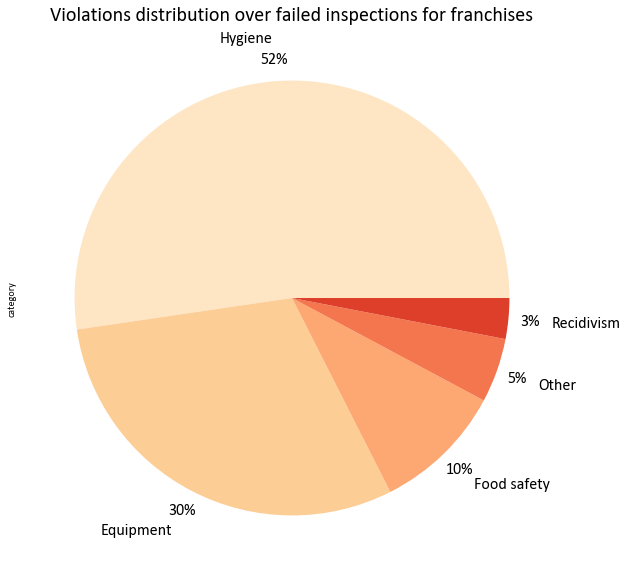

In [30]:
fail_violation = groups_violations[groups_violations.result == 'Fail']
fail_violation = fail_violation[fail_violation.id != 'None']
fail_violation['category'] = fail_violation.id.astype('int32').map(violation_category_mapping.get)
fail_violation = fail_violation[~fail_violation.category.isna()]
fail_violation['v_count'] = 1
#fail_violation = fail_violation.drop('id', axis=1)

fig, ax = plt.subplots(figsize=(10, 10))
sns.set_palette(sns.color_palette("OrRd", 6))

failures = fail_violation.category.value_counts() / fail_violation.shape[0]
pie = failures.plot.pie(autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, ax=ax, textprops={'fontsize': 16})
pie.set_title('Violations distribution over failed inspections for franchises', fontsize=20)
fig.savefig('results/general/failure_related_violations.png')